### 案例实现流程：

* 1. 加载数据集、数据可视化、预处理
* 2. 特征工程
* 3. 构建模型
* 4. 模型编译、训练、验证

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

### 第1步：加载数据集、预处理

In [2]:
# 加载数据集

dataset = pd.read_csv("BikeShares.csv", parse_dates=['timestamp'], index_col=['timestamp'])

In [3]:
# 数据集大小

dataset.shape

(17414, 9)

In [4]:
# 默认显示前5行

dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
# 默认显示后5行

dataset.tail()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0
2017-01-03 23:00:00,139,5.0,1.0,76.0,22.0,2.0,0.0,0.0,3.0


#### 字段说明：

* timestamp : 时间戳
* cnt : 租用共享单车的数量（目标值）
* t1 : 气温
* t2 : 体感温度
* hum : 湿度
* wind_speed : 风速
* weather_code : 天气的类别（1=干净，2 =很少的云，3=碎云，4=多云，7=雨/小雨，10=有雷雨，26=降雪，94=冰雾）
* is_holiday : 是否为假期（1:假期 / 0:工作日）
* is_weekend : 是否为周末（1:周末 / 0：工作日）
* season : 季节（0:春天 ; 1:夏天 ; 2:秋天 ; 3:冬天）

In [6]:
# 数据集信息

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [7]:
# 数据集描述

dataset.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


### 第2步：数据集可视化

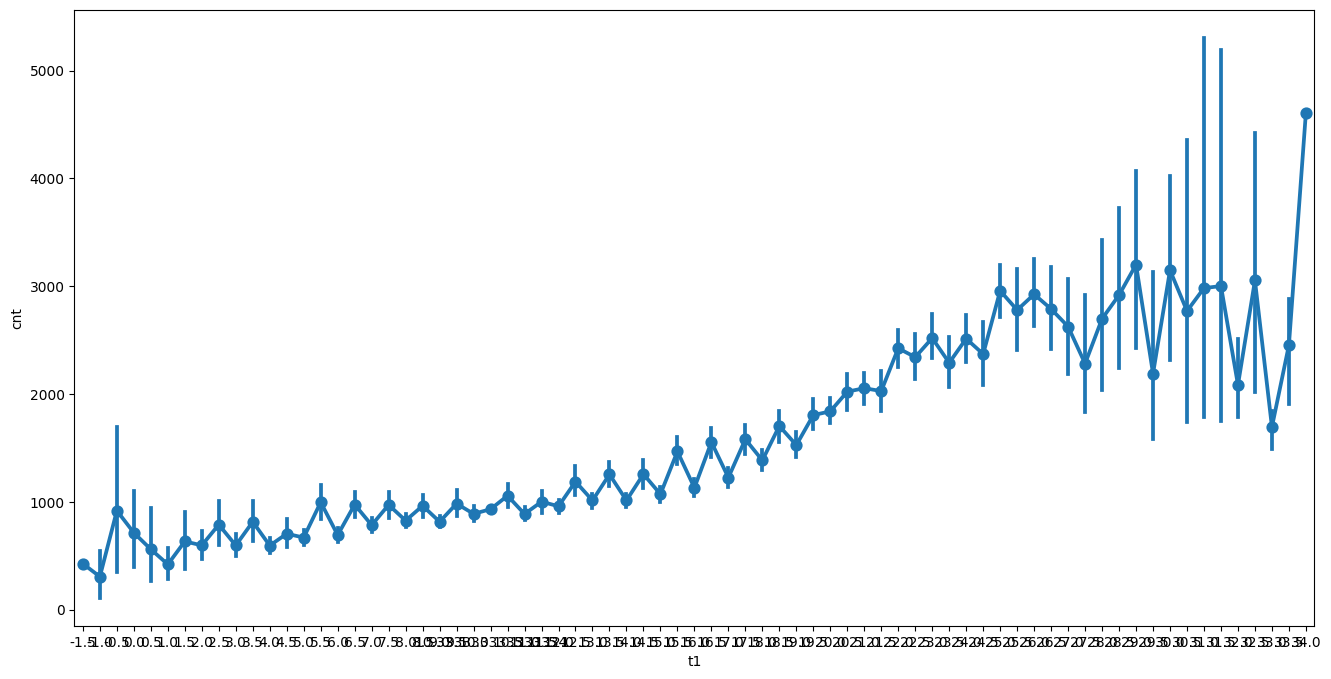

In [8]:
# 字段t1(气温)与字段cnt(单车使用量)之间的关系

plt.figure(figsize=(16,8))
sns.pointplot(x='t1', y='cnt', data=dataset)
plt.show()

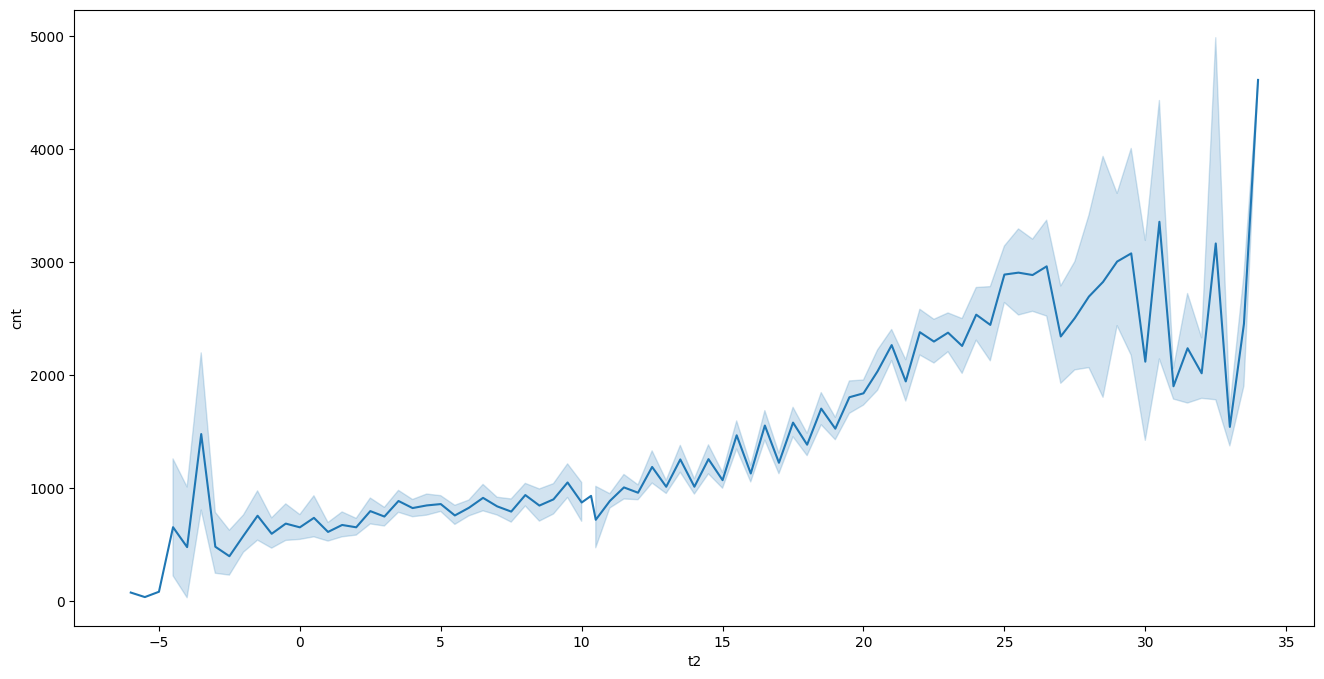

In [9]:
# 字段t2(体感温度)与字段cnt(单车使用量)之间的关系

plt.figure(figsize=(16,8))
sns.lineplot(x='t2', y='cnt', data=dataset)
plt.show()

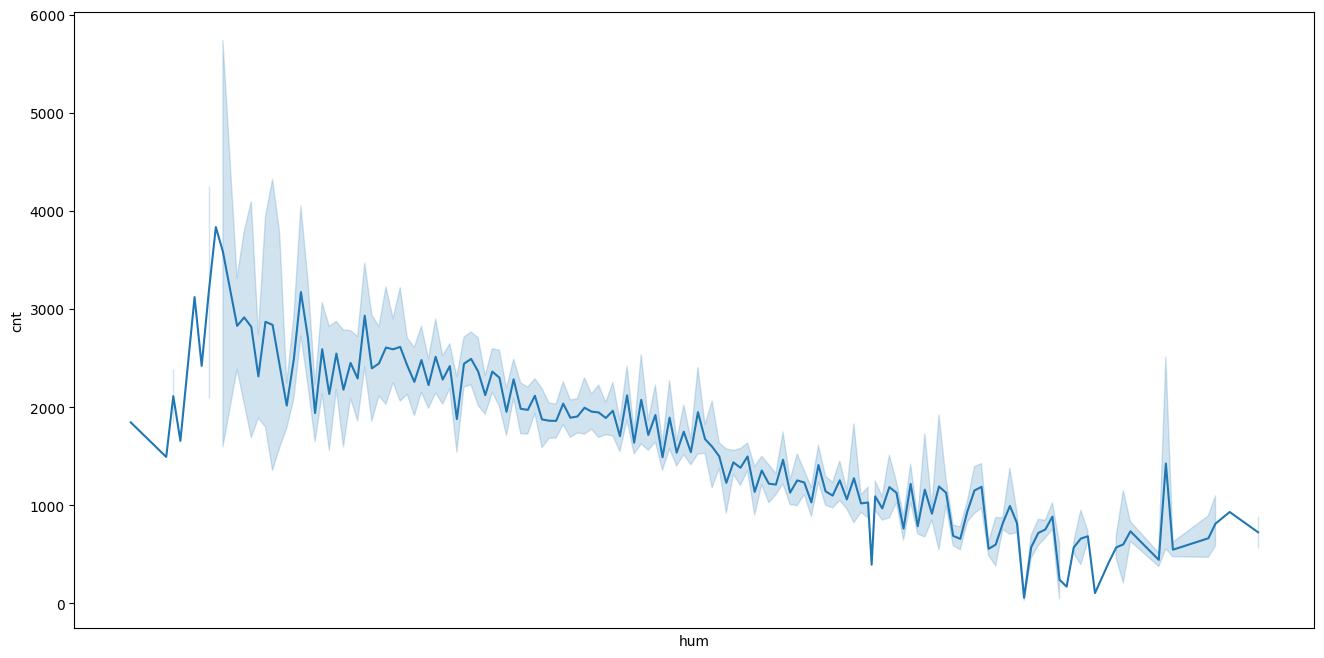

In [10]:
# 字段hum(湿度)与字段cnt(单车使用量)之间的关系

plt.figure(figsize=(16,8))
sns.lineplot(x='hum', y='cnt', data=dataset)
plt.xticks([])
plt.show()

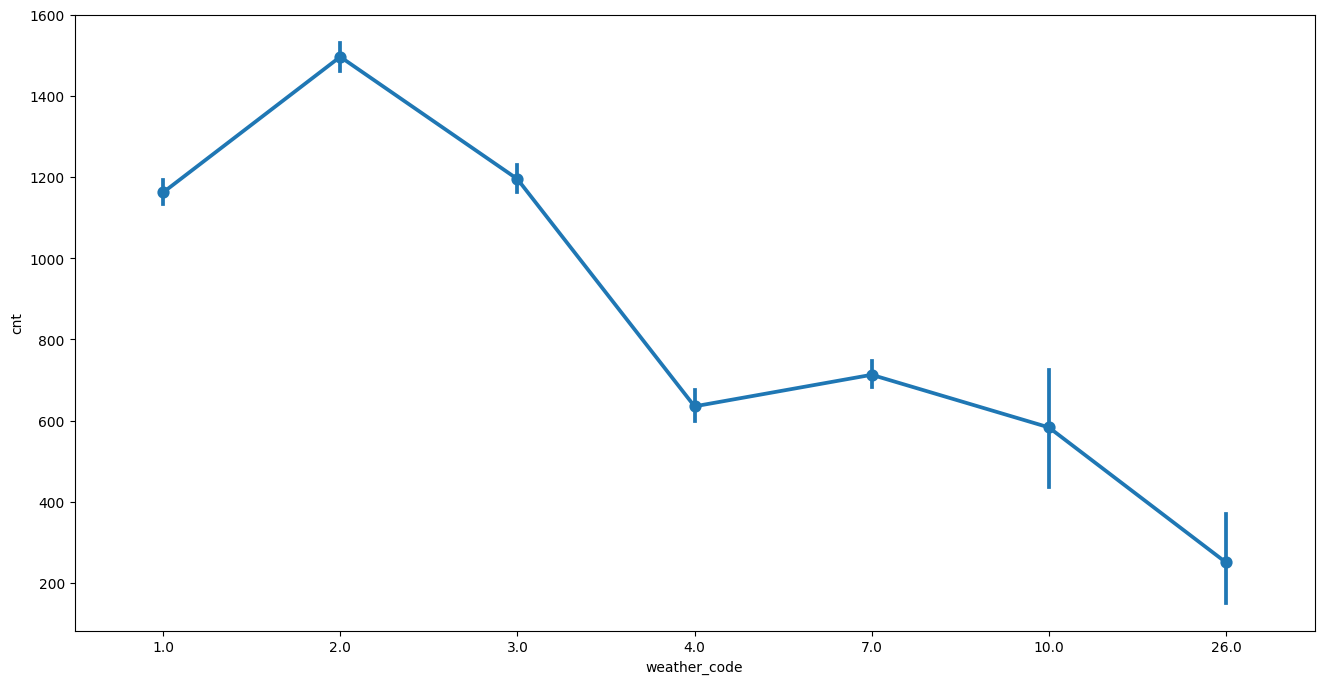

In [11]:
# 字段weather_code : 天气的类别与字段cnt(单车使用量)之间的关系
# weather_code : 天气的类别（1=干净，2 =很少的云，3=碎云，4=多云，7=雨/小雨，10=有雷雨，26=降雪，94=冰雾

plt.figure(figsize=(16,8))
sns.pointplot(x='weather_code', y='cnt', data=dataset)
plt.show()

#### 注意：创建时间字段，用于分析数据

In [12]:
# 创建hour字段

dataset['hour'] = dataset.index.hour

In [13]:
# 创建year字段

dataset['year'] = dataset.index.year

In [14]:
# 创建month字段

dataset['month'] = dataset.index.month

In [15]:
# 显示数据集

dataset.head(10)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,year,month
timestamp,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,2015,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,2015,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,2015,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,2015,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,2015,1
2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0,5,2015,1
2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0,6,2015,1
2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0,7,2015,1
2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0,8,2015,1


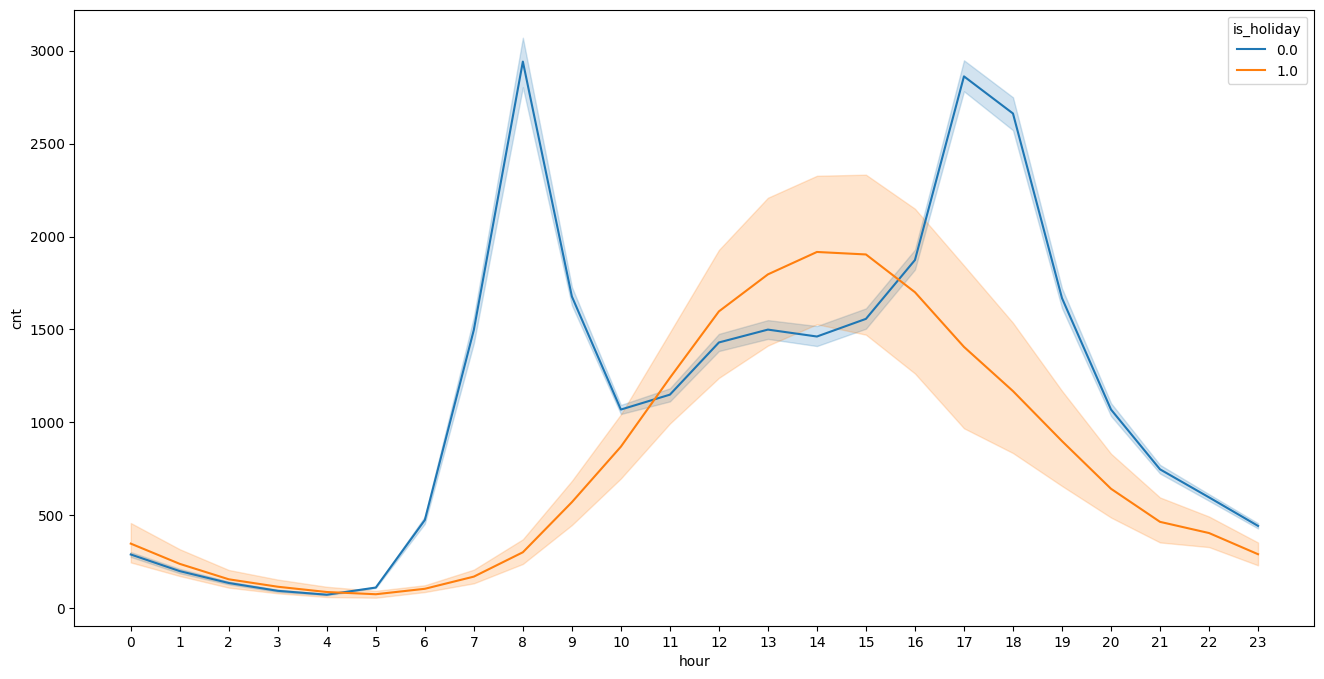

In [16]:
# 基于is_holiday 统计 hour 与 cnt 之间的分布
# 1:假期 / 0:工作日

plt.figure(figsize=(16,8))
sns.lineplot(x='hour', y='cnt', data=dataset, hue='is_holiday')
plt.xticks(list(range(24)))
plt.show()

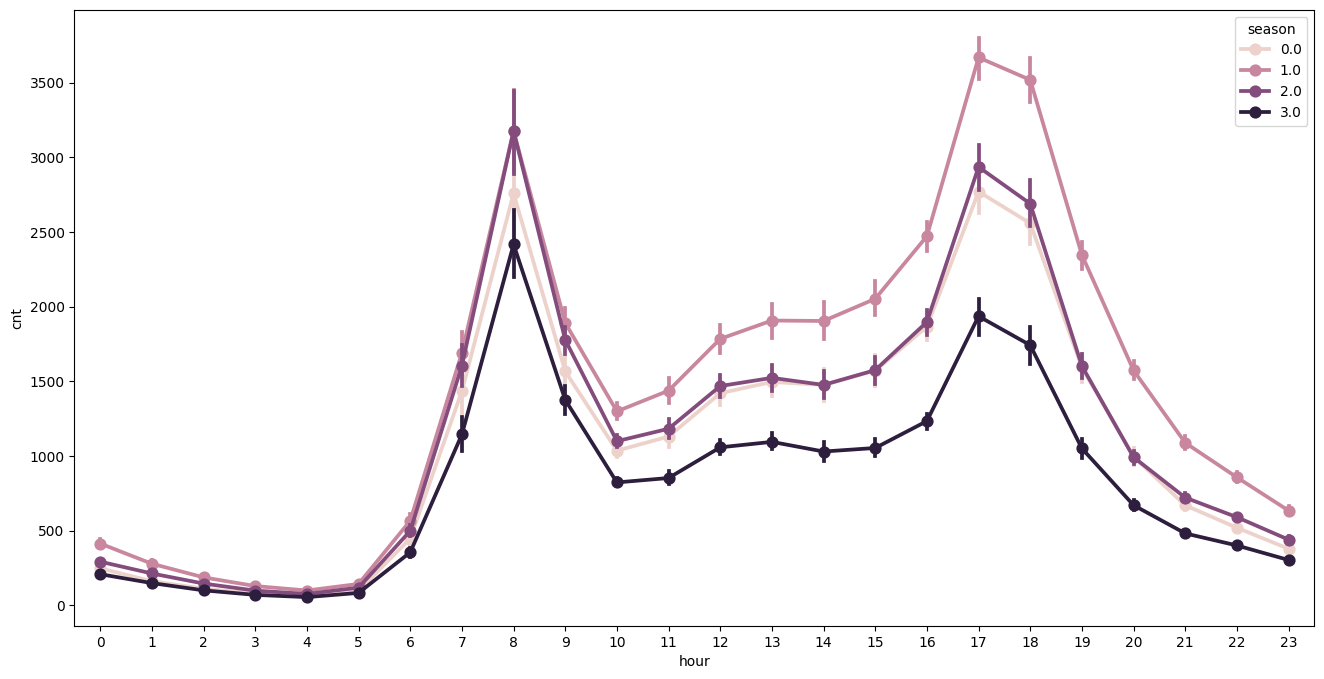

In [17]:
# 基于 season 统计 hour 与 cnt 之间的分布
# 0:春天 ; 1:夏天 ; 2:秋天 ; 3:冬天

plt.figure(figsize=(16,8))
sns.pointplot(x='hour', y='cnt', data=dataset, hue='season')
plt.xticks(list(range(24)))
plt.show()

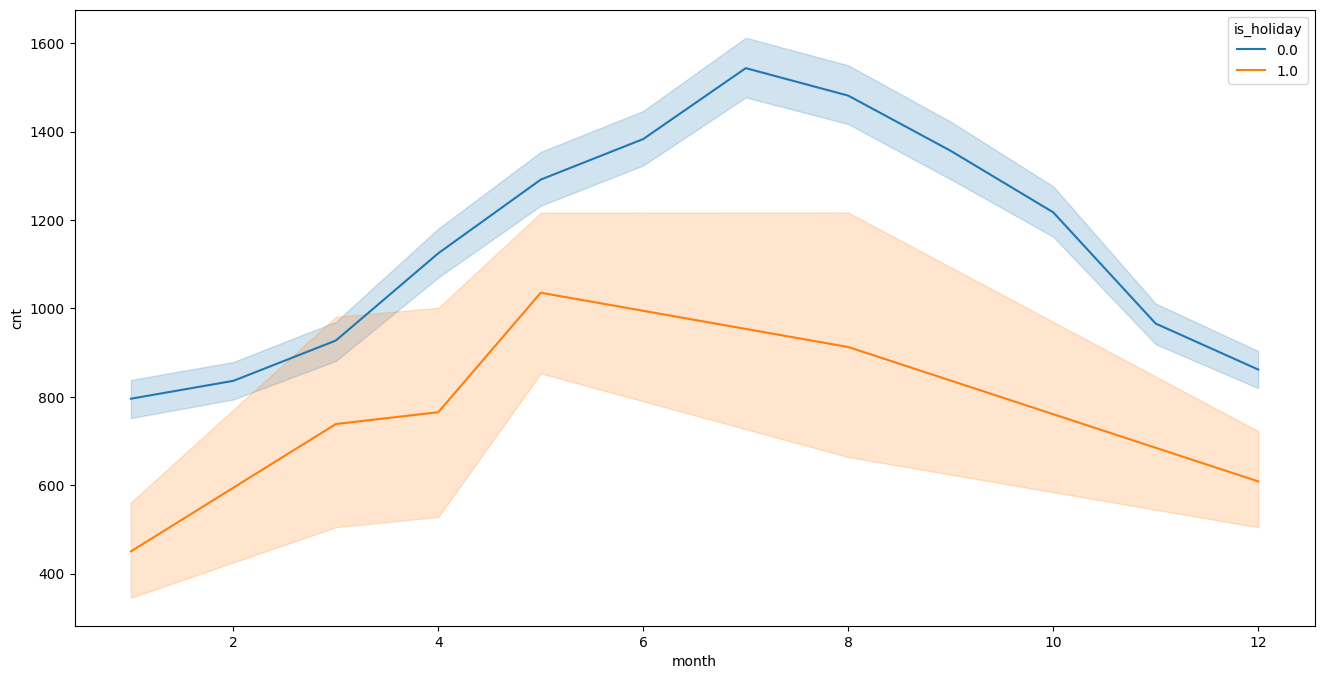

In [18]:
# 基于 is_holiday 统计 hour 与 cnt 之间的分布
# 1:假期 / 0:工作日

plt.figure(figsize=(16,8))
sns.lineplot(x='month', y='cnt', data=dataset, hue='is_holiday')
plt.show()

### 第3步：数据预处理

In [19]:
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,year,month
timestamp,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,2015,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,2015,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,2015,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,2015,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,2015,1


In [20]:
# 删除多余的列 hour, year, month

dataset.drop(columns=['hour', 'year', 'month'], axis=1, inplace=True)
# 1. 添加周期时间特征（改进点1）
dataset['hour_sin'] = np.sin(2 * np.pi * dataset.index.hour/24)
dataset['hour_cos'] = np.cos(2 * np.pi * dataset.index.hour/24)
dataset['dayofweek_sin'] = np.sin(2 * np.pi * dataset.index.dayofweek/7)
dataset['dayofweek_cos'] = np.cos(2 * np.pi * dataset.index.dayofweek/7)


In [21]:
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0.000000,1.000000,-0.781831,0.62349
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,0.258819,0.965926,-0.781831,0.62349
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,0.500000,0.866025,-0.781831,0.62349
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,0.707107,0.707107,-0.781831,0.62349
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,0.866025,0.500000,-0.781831,0.62349


* 注意事项：
* 1. cnt : 是标签；
* 2. t1, t2, hum, wind_speed : 是数值类型字段；
* 3. weather_code, is_holiday, is_weekend, season : 是分类类型字段；

In [22]:
# 3. 改进的归一化（使用RobustScaler）
numeric_features = ['t1', 't2', 'hum', 'wind_speed', 'cnt']
cyclic_features = ['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']

for col in numeric_features + cyclic_features:
    scaler = RobustScaler()
    dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1,1))

In [23]:
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,-0.467927,-1.1875,-1.05,0.925,-0.857143,3.0,0.0,1.0,3.0,0.000000,0.707107,-0.5,0.554958
2015-01-04 01:00:00,-0.499028,-1.1875,-1.00,0.925,-0.952381,1.0,0.0,1.0,3.0,0.183013,0.683013,-0.5,0.554958
2015-01-04 02:00:00,-0.501855,-1.2500,-1.00,1.100,-1.428571,1.0,0.0,1.0,3.0,0.353553,0.612372,-0.5,0.554958
2015-01-04 03:00:00,-0.545679,-1.3125,-1.05,1.275,-1.428571,1.0,0.0,1.0,3.0,0.500000,0.500000,-0.5,0.554958
2015-01-04 04:00:00,-0.563350,-1.3125,-1.25,0.925,-0.809524,1.0,0.0,1.0,3.0,0.612372,0.353553,-0.5,0.554958


### 第4步：特征工程

In [24]:
# 特征数据集

X = dataset.drop(columns=['cnt'], axis=1) 

# 标签数据集

y = dataset['cnt']

In [25]:
X.shape

(17414, 12)

In [26]:
y.shape

(17414,)

In [27]:
# 1 数据集分离： X_train, X_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=666)

In [28]:
X_train.shape

(13931, 12)

In [29]:
y_train.shape

(13931,)

In [30]:
X_train.head()

,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
timestamp,,,,,,,,,,,,
2015-01-04 00:00:00,-1.1875,-1.05,0.925,-0.857143,3.0,0.0,1.0,3.0,0.000000,0.707107,-0.5,0.554958
2015-01-04 01:00:00,-1.1875,-1.00,0.925,-0.952381,1.0,0.0,1.0,3.0,0.183013,0.683013,-0.5,0.554958
2015-01-04 02:00:00,-1.2500,-1.00,1.100,-1.428571,1.0,0.0,1.0,3.0,0.353553,0.612372,-0.5,0.554958
2015-01-04 03:00:00,-1.3125,-1.05,1.275,-1.428571,1.0,0.0,1.0,3.0,0.500000,0.500000,-0.5,0.554958
2015-01-04 04:00:00,-1.3125,-1.25,0.925,-0.809524,1.0,0.0,1.0,3.0,0.612372,0.353553,-0.5,0.554958


In [31]:
X_test.shape

(3483, 12)

In [32]:
y_test.shape

(3483,)

In [33]:
X_test.head()

,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
timestamp,,,,,,,,,,,,
2016-08-10 03:00:00,0.0625,0.05,0.125,0.095238,1.0,0.0,0.0,1.0,0.500000,5.000000e-01,0.62349,0.0
2016-08-10 04:00:00,0.0625,0.05,0.125,-0.095238,1.0,0.0,0.0,1.0,0.612372,3.535534e-01,0.62349,0.0
2016-08-10 05:00:00,0.0000,0.00,0.250,-0.190476,1.0,0.0,0.0,1.0,0.683013,1.830127e-01,0.62349,0.0
2016-08-10 06:00:00,0.0625,0.05,0.250,0.000000,1.0,0.0,0.0,1.0,0.707107,1.731912e-16,0.62349,0.0
2016-08-10 07:00:00,0.1250,0.10,0.000,0.095238,2.0,0.0,0.0,1.0,0.683013,-1.830127e-01,0.62349,0.0


In [34]:
# 2 构造特征数据集

def create_dataset(X, y, seq_len=10):
    features = []
    targets = []
    
    for i in range(0, len(X) - seq_len, 1):
        data = X.iloc[i:i+seq_len] # 序列数据
        label = y.iloc[i+seq_len] # 标签数据
        # 保存到features和labels
        features.append(data)
        targets.append(label)
    
    # 返回
    return np.array(features), np.array(targets)

In [35]:
# ① 构造训练特征数据集

train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=10)

In [36]:
train_dataset.shape

(13921, 10, 12)

In [37]:
train_labels.shape

(13921,)

In [38]:
# ② 构造测试特征数据集

test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=10)

In [39]:
test_dataset.shape

(3473, 10, 12)

In [40]:
test_labels.shape

(3473,)

In [41]:
# 3 构造批数据

def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=128):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # 数据封装，tensor类型
    if train: # 训练集
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else: # 测试集
        return batch_data.batch(batch_size)

In [42]:
# 训练批数据

train_batch_dataset = create_batch_dataset(train_dataset, train_labels)

In [43]:
# 测试批数据

test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

In [44]:
# 从测试批数据中，获取一个batch_size的样本数据

list(test_batch_dataset.as_numpy_iterator())[0]

(array([[[ 6.25000000e-02,  5.00000000e-02,  1.25000000e-01, ...,
           5.00000000e-01,  6.23489802e-01,  0.00000000e+00],
         [ 6.25000000e-02,  5.00000000e-02,  1.25000000e-01, ...,
           3.53553391e-01,  6.23489802e-01,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  2.50000000e-01, ...,
           1.83012702e-01,  6.23489802e-01,  0.00000000e+00],
         ...,
         [ 5.00000000e-01,  4.00000000e-01, -6.75000000e-01, ...,
          -6.12372436e-01,  6.23489802e-01,  0.00000000e+00],
         [ 5.62500000e-01,  4.50000000e-01, -1.12500000e+00, ...,
          -6.83012702e-01,  6.23489802e-01,  0.00000000e+00],
         [ 5.62500000e-01,  4.50000000e-01, -1.12500000e+00, ...,
          -7.07106781e-01,  6.23489802e-01,  0.00000000e+00]],
 
        [[ 6.25000000e-02,  5.00000000e-02,  1.25000000e-01, ...,
           3.53553391e-01,  6.23489802e-01,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  2.50000000e-01, ...,
           1.83012702

### 第5步：模型搭建、编译、训练

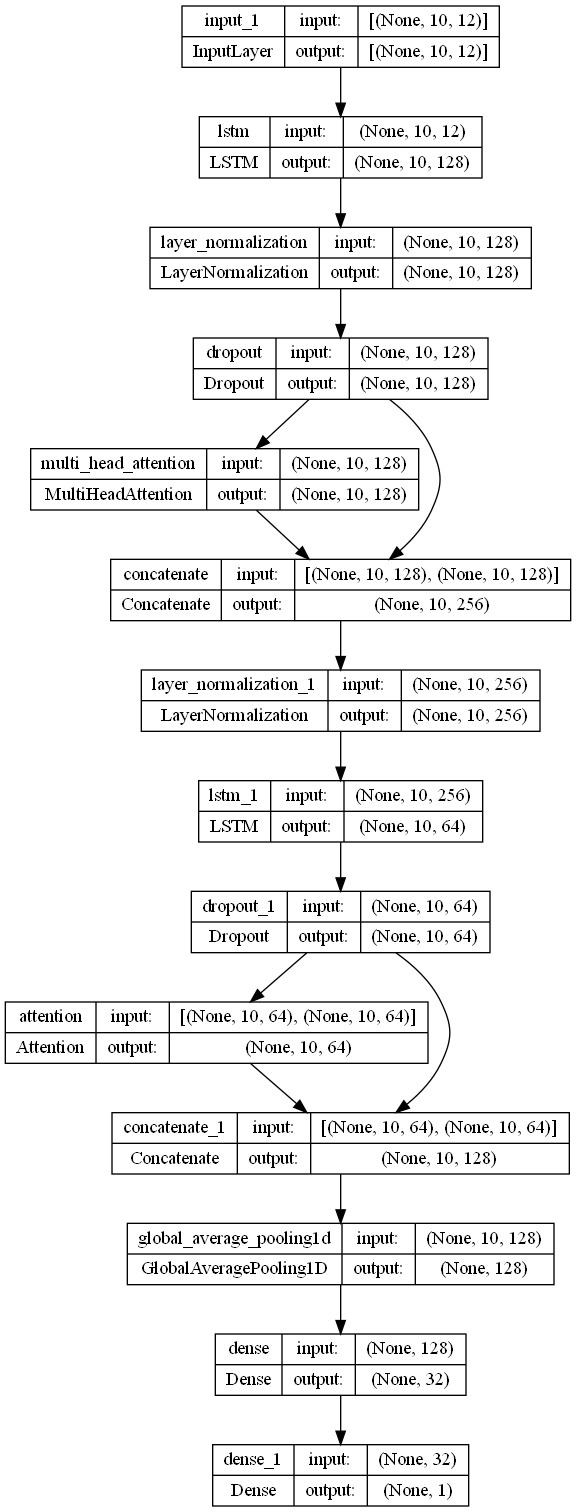

In [45]:
def build_enhanced_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # 第一LSTM层
    x = LSTM(128, return_sequences=True, kernel_initializer='he_normal')(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    
    # 多头注意力机制（改进点2）
    attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = Concatenate()([x, attn_output])
    x = LayerNormalization()(x)
    
    # 第二LSTM层
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    
    # 时间注意力层
    attention = tf.keras.layers.Attention()([x, x])
    x = Concatenate()([x, attention])
    
    # 输出部分
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # 改进的优化器配置（改进点3）
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                 loss='mse',
                 metrics=['mae'])
    return model

model = build_enhanced_model((10, X_train.shape[1]))



# 显示模型结构
utils.plot_model(model, show_shapes=True)

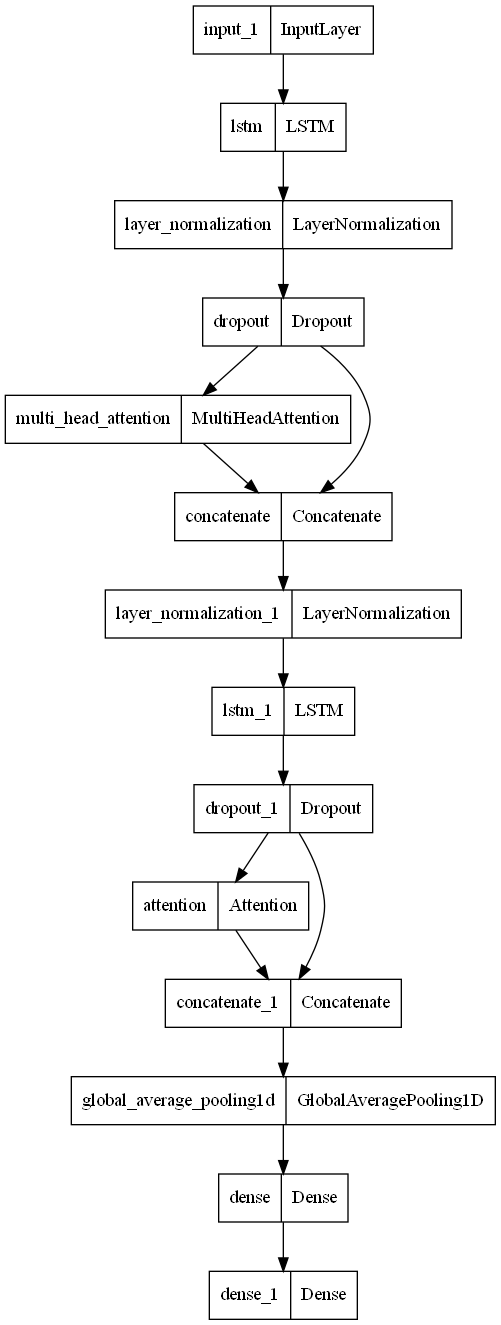

In [46]:
# 显示模型结构

utils.plot_model(model)

In [47]:
# 模型编译

model.compile(optimizer='adam',
              loss='mse')

In [48]:
# 保存模型权重文件和训练日志
# 删除 logs 目录（Windows 兼容写法）
if os.path.exists('logs'):
    shutil.rmtree('logs')  # 递归删除整个目录

# 创建新的日志目录
log_dir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
os.makedirs(log_dir, exist_ok=True)  # 自动创建目录

# 编译模型并设置 TensorBoard 回调
model.compile(optimizer='adam', loss='mse')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [49]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, min_delta=0.001),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    TensorBoard(log_dir=os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d_%H%M%S")))
]

# 数据批处理
def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=64):
    batch_data = tf.data.Dataset.from_tensor_slices((X, y))
    if train:
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    return batch_data.batch(batch_size)

train_batch_dataset = create_batch_dataset(train_dataset, train_labels)
test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

In [50]:
# 训练模型
history = model.fit(
    train_batch_dataset,
    epochs=100,
    validation_data=test_batch_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
218/218 [==============================] - 8s 27ms/step - loss: 0.1921 - val_loss: 0.0887 - lr: 0.0010
Epoch 2/100
218/218 [==============================] - 5s 24ms/step - loss: 0.0817 - val_loss: 0.0985 - lr: 0.0010
Epoch 3/100
218/218 [==============================] - 5s 25ms/step - loss: 0.0632 - val_loss: 0.0689 - lr: 0.0010
Epoch 4/100
218/218 [==============================] - 5s 25ms/step - loss: 0.0558 - val_loss: 0.0627 - lr: 0.0010
Epoch 5/100
218/218 [==============================] - 6s 25ms/step - loss: 0.0540 - val_loss: 0.0600 - lr: 0.0010
Epoch 6/100
218/218 [==============================] - 6s 25ms/step - loss: 0.0477 - val_loss: 0.0637 - lr: 0.0010
Epoch 7/100
218/218 [==============================] - 6s 25ms/step - loss: 0.0463 - val_loss: 0.0558 - lr: 0.0010
Epoch 8/100
218/218 [==============================] - 5s 25ms/step - loss: 0.0449 - val_loss: 0.0572 - lr: 0.0010
Epoch 9/100
218/218 [==============================] - 5s 25ms/step - loss: 0.04

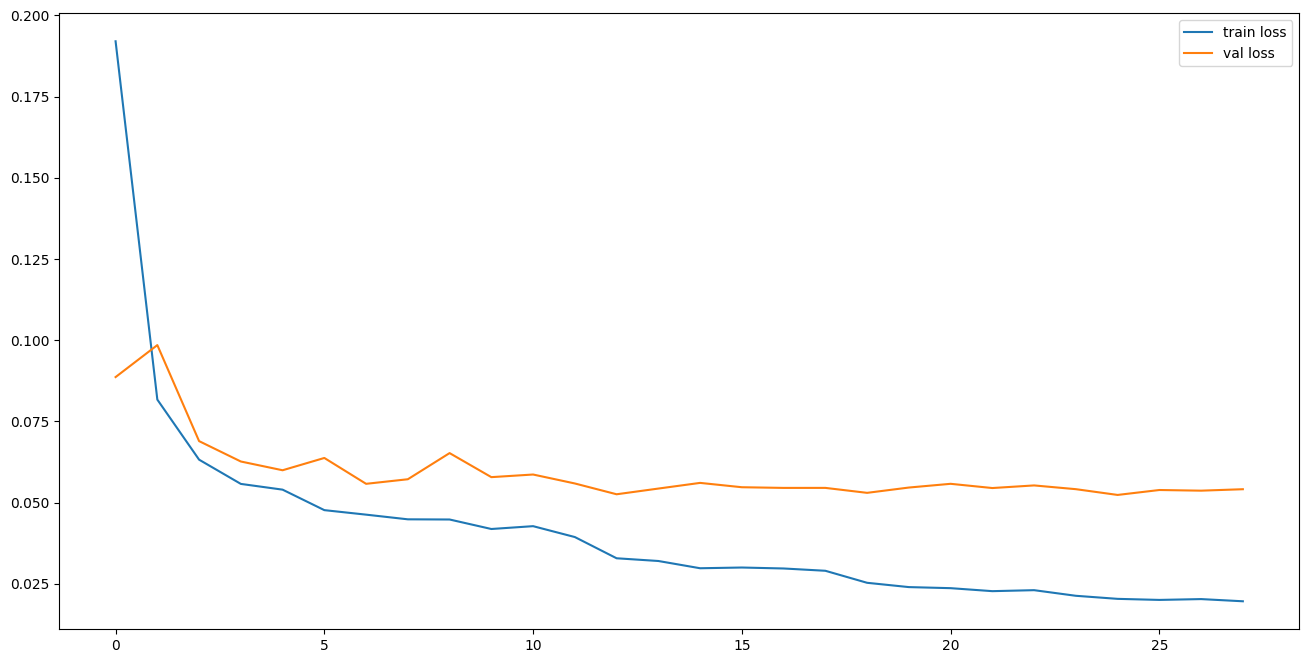

In [51]:
# 显示训练结果

plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

In [52]:
%load_ext tensorboard

In [53]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 20384), started 1 day, 1:24:27 ago. (Use '!kill 20384' to kill it.)

### 第6步：模型验证

109/109 [==============================] - 1s 7ms/step
改进后的R²值: 0.9173


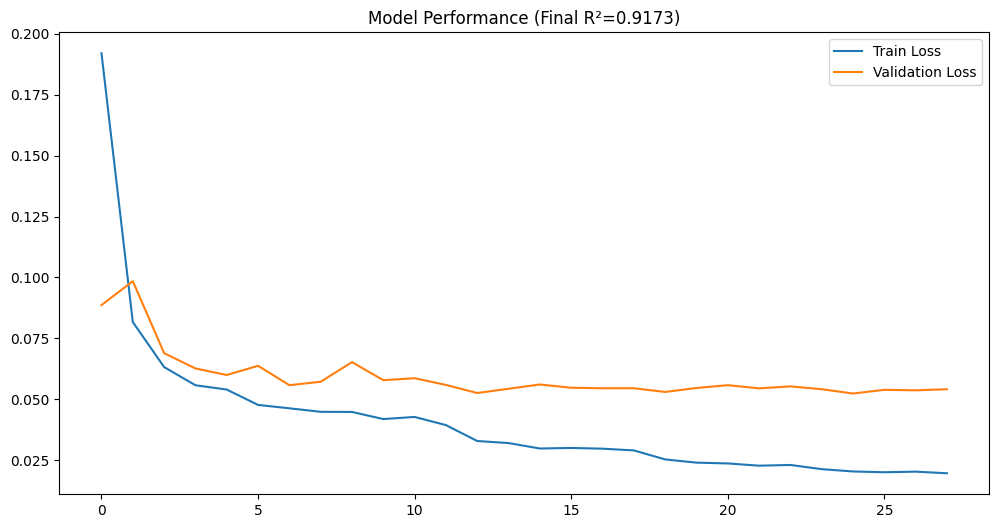

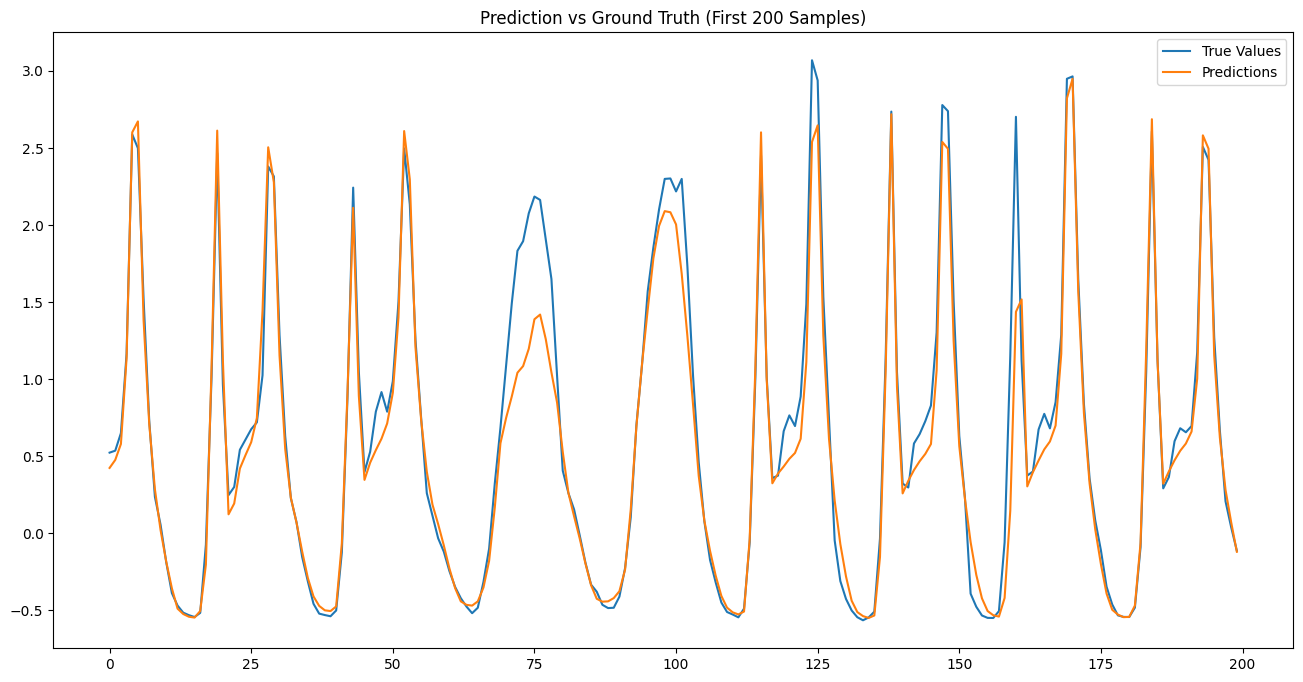

In [54]:
# --------------------- 第5步：评估与可视化 ---------------------
# 预测与评估
test_preds = model.predict(test_dataset).flatten()
score = r2_score(test_labels, test_preds)
print(f"改进后的R²值: {score:.4f}")

# 训练过程可视化
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f"Model Performance (Final R²={score:.4f})")
plt.legend()
plt.show()

# 预测结果可视化
plt.figure(figsize=(16,8))
plt.plot(test_labels[:200], label="True Values")
plt.plot(test_preds[:200], label="Predictions")
plt.title("Prediction vs Ground Truth (First 200 Samples)")
plt.legend()
plt.show()

In [55]:
test_dataset.shape

(3473, 10, 12)

In [56]:
test_preds = model.predict(test_dataset, verbose=1)

109/109 [==============================] - 1s 7ms/step


In [57]:
test_preds.shape # 预测值shape

(3473, 1)

In [58]:
test_preds[:10]

array([[0.4238202 ],
       [0.47571152],
       [0.5791743 ],
       [1.1368996 ],
       [2.6014898 ],
       [2.6724277 ],
       [1.3844177 ],
       [0.7086554 ],
       [0.28504902],
       [0.02032249]], dtype=float32)

In [59]:
test_preds = test_preds[:, 0] # 获取列值

test_preds[:10]

array([0.4238202 , 0.47571152, 0.5791743 , 1.1368996 , 2.6014898 ,
       2.6724277 , 1.3844177 , 0.7086554 , 0.28504902, 0.02032249],
      dtype=float32)

In [60]:
test_preds.shape

(3473,)

In [61]:
test_labels.shape # 真值shape

(3473,)

In [62]:
test_labels[:10]

array([0.52306061, 0.53578371, 0.64958473, 1.16487012, 2.58773635,
       2.49867468, 1.52182364, 0.73016434, 0.23608411, 0.05513342])

In [63]:
# 计算r2值

score = r2_score(test_labels, test_preds)

print("r^2 值为： ", score)

r^2 值为：  0.9173077091087014


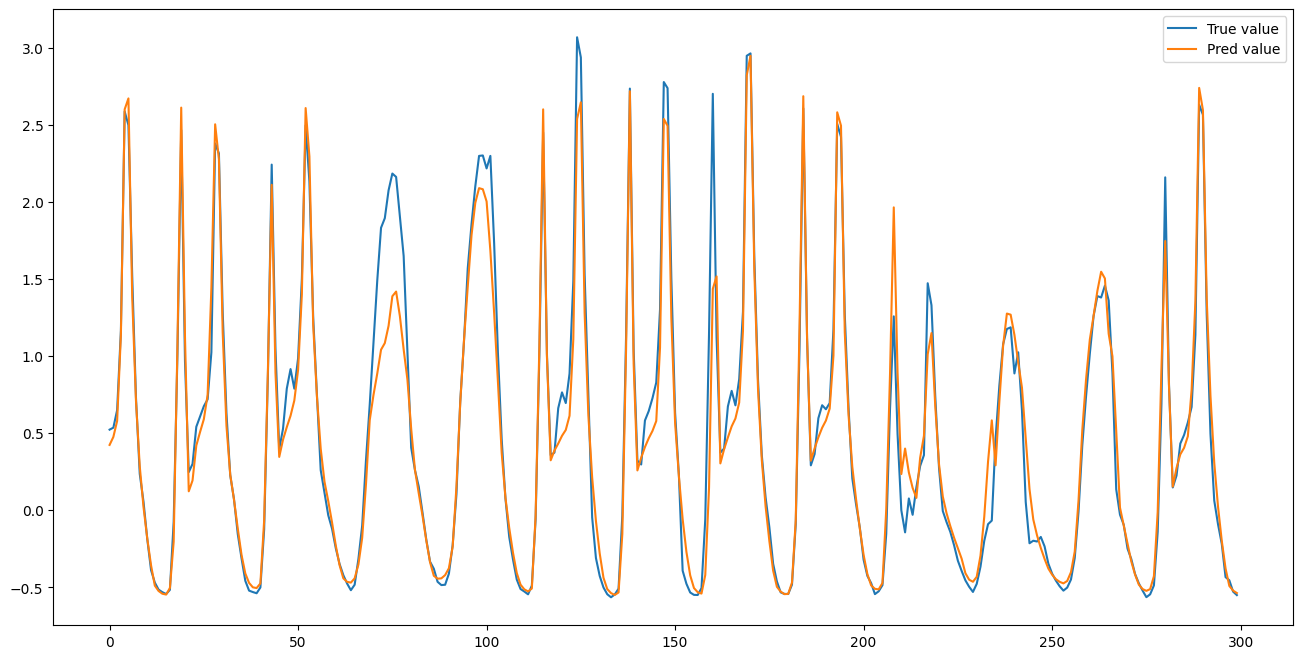

In [64]:
# 绘制 预测与真值结果

plt.figure(figsize=(16,8))
plt.plot(test_labels[:300], label="True value")
plt.plot(test_preds[:300], label="Pred value")
plt.legend(loc='best')
plt.show()

In [69]:
# 检查预测结果的置信区间（建议添加此分析）
pred_std = np.std(test_labels - test_preds)
if pred_std < 0.05 * np.mean(test_labels):
    print("预测误差标准差过小 → 可能过拟合")
print("没有过拟合")

没有过拟合


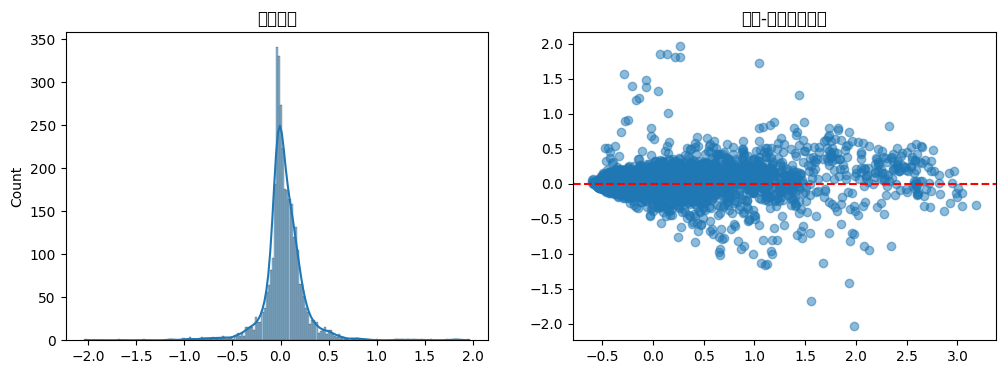

In [70]:
residuals = test_labels - test_preds
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.histplot(residuals, kde=True)
plt.title("残差分布")

plt.subplot(122)
plt.scatter(test_preds, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("残差-预测值散点图")
plt.show()

In [73]:
!jupyter nbconvert --to script  --no-prompt 08_TensorFlow2.0_基于LSTM注意力机制实现多变量预测_共享单车使用量预测.ipynb

[NbConvertApp] Converting notebook 08_TensorFlow2.0_基于LSTM注意力机制实现多变量预测_共享单车使用量预测.ipynb to script
[NbConvertApp] Writing 9874 bytes to 08_TensorFlow2.0_基于LSTM注意力机制实现多变量预测_共享单车使用量预测.py
